# Algoritmo Suport Vector Machine

In [1]:
import os, sys
import pandas as pd
import matplotlib.pyplot as plt

from spacy.lang.pt import Portuguese

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

2022-06-11 22:38:35.938564: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-11 22:38:35.938678: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Importing helper

In [2]:
# Importing custom functions (temp)
current_dir = os.path.abspath('')
parent_dir = os.path.dirname(current_dir)
parent_dir = os.path.dirname(parent_dir)
sys.path.append(parent_dir)

from helpers.string_cleaner import StringCleaner as sc

### 1. Processamento Dataset

#### 1.1 Extrair dataset

In [3]:
true_ds = pd.read_csv('datasets/base/true.csv')
fake_ds = pd.read_csv('datasets/base/fake.csv')

In [4]:
true_ds['target'] = 0
fake_ds['target'] = 1

In [5]:
fake_df = pd.DataFrame(fake_ds)
true_df = pd.DataFrame(true_ds)

df = pd.concat([fake_df, true_ds])
# pd.set_option('display.max_colwidth', None)

#### 1.2 Limpar o dataframe

**Observações**:
* Verificar a necessidade de adicionar as siglas dos estados brasileiros como stop words.
* Verificar a necessidade de remover o conteúdo entre colchetes e parênteses.
* Verificar a necessidade de remover formatação de datas e horários
* Verificar a necessidade de remover caracteres especiais, como: cedilha, acentos, etc.

In [6]:
# stop words using spaCy
nlp_pt = Portuguese()
stopwords = nlp_pt.Defaults.stop_words
# nlp_pt.Defaults.stop_words.remove('sem')
# nlp_pt.Defaults.stop_words.add('to')

def remove_stopwords(text):
    final_text = []
    for token in text.split():
      if token.lower() not in stopwords:
          final_text.append(token)
    return " ".join(final_text)

def denoise_text(text):
    text = sc.remove_url(text)
    text = sc.remove_special_characters(text)
    text = remove_stopwords(text)

    return text.lower()

df['full_text'] = df['full_text'].apply(denoise_text)

### 2. Aplicar Support Vector Machine

#### 2.1 Dividindo o dataset e transformando em um array vetorizado

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df['full_text'],
    df['target'],
    random_state=0,
    test_size=.3
)

#### 2.2 Vetorização do texto

In [8]:
vectorizer = CountVectorizer(ngram_range=(1,1)).fit(X_train)

In [9]:
X_train_vectorized = vectorizer.fit_transform(X_train)

#### 2.2 Criando um modelo de Naive Bayes e o treinando com o dataset

In [10]:
svm_model = svm.SVC()
svm_model.fit(X_train_vectorized, Y_train)

SVC()

#### 2.3 Realizando uma predição

In [11]:
svm_Y_predict = svm_model.predict(vectorizer.transform(X_test))

#### 2.5 Observando a precisão

In [12]:
accuracy = accuracy_score(Y_test, svm_Y_predict)*100
print(str(accuracy) + " %")

95.55555555555556 %


#### 2.6 Métricas mais detalhadas

In [13]:
report = classification_report(Y_test, svm_Y_predict, digits=7)
print(report)

              precision    recall  f1-score   support

           0  0.9666349 0.9432558 0.9548023      1075
           1  0.9450945 0.9677419 0.9562842      1085

    accuracy                      0.9555556      2160
   macro avg  0.9558647 0.9554989 0.9555432      2160
weighted avg  0.9558148 0.9555556 0.9555466      2160



#### 2.4 Executando uma matrix de confusão

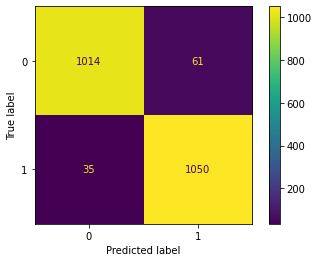

In [14]:
# just in the confusion matrix, we have:
# 1 [true] -> as true news
# 0 [false] => as fake news
cm = confusion_matrix(Y_test, svm_Y_predict)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot()
plt.show()